<a href="https://colab.research.google.com/github/ldm2060/LearningNote/blob/main/DL%202023.6/week3/%E4%BD%9C%E4%B8%9A/ML2022Spring_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2 Phoneme Classification**

* Slides: https://docs.google.com/presentation/d/1v6HkBWiJb8WNDcJ9_-2kwVstxUWml87b9CnA16Gdoio/edit?usp=sharing
* Kaggle: https://www.kaggle.com/c/ml2022spring-hw2
* Video: TBA


In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## Download Data
Download data from google drive, then unzip it.

You should have
- `libriphone/train_split.txt`
- `libriphone/train_labels`
- `libriphone/test_split.txt`
- `libriphone/feat/train/*.pt`: training feature<br>
- `libriphone/feat/test/*.pt`:  testing feature<br>

after running the following block.

> **Notes: if the google drive link is dead, you can download the data directly from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw2/data) and upload it to the workspace**


### Download train/test metadata

In [2]:
!pip install --upgrade gdown

# Main link
!gdown --id '1o6Ag-G3qItSmYhTheX6DYiuyNzWyHyTc' --output libriphone.zip

# Backup link 1
# !gdown --id '1R1uQYi4QpX0tBfUWt2mbZcncdBsJkxeW' --output libriphone.zip

# Bqckup link 2
# !wget -O libriphone.zip "https://www.dropbox.com/s/wqww8c5dbrl2ka9/libriphone.zip?dl=1"

!unzip -q libriphone.zip
!ls libriphone

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1o6Ag-G3qItSmYhTheX6DYiuyNzWyHyTc
From (redirected): https://drive.google.com/uc?id=1o6Ag-G3qItSmYhTheX6DYiuyNzWyHyTc&confirm=t&uuid=116e46a4-37a2-4bd1-b6d9-0cec084a6b08
To: /content/libriphone.zip
100% 479M/479M [00:12<00:00, 37.4MB/s]
feat  test_split.txt  train_labels.txt	train_split.txt


### Preparing Data

**Helper functions to pre-process the training data from raw MFCC features of each utterance.**

A phoneme may span several frames and is dependent to past and future frames. \
Hence we concatenate neighboring phonemes for training to achieve higher accuracy. The **concat_feat** function concatenates past and future k frames (total 2k+1 = n frames), and we predict the center frame.

Feel free to modify the data preprocess functions, but **do not drop any frame** (if you modify the functions, remember to check that the number of frames are the same as mentioned in the slides)

In [3]:
import os
import random
import pandas as pd
import torch
from tqdm import tqdm

def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x, n):
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]

    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x, concat_n):
    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    x = x.repeat(1, concat_n)
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim)

def preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8, train_val_seed=1337):
    class_num = 41 # NOTE: pre-computed, should not need change
    mode = 'train' if (split == 'train' or split == 'val') else 'test'

    label_dict = {}
    if mode != 'test':
      phone_file = open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines()

      for line in phone_file:
          line = line.strip('\n').split(' ')
          label_dict[line[0]] = [int(p) for p in line[1:]]

    if split == 'train' or split == 'val':
        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.seed(train_val_seed)
        random.shuffle(usage_list)
        percent = int(len(usage_list) * train_ratio)
        usage_list = usage_list[:percent] if split == 'train' else usage_list[percent:]
    elif split == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    usage_list = [line.strip('\n') for line in usage_list]
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode != 'test':
      y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
        feat = concat_feat(feat, concat_nframes)
        if mode != 'test':
          label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat
        if mode != 'test':
          y[idx: idx + cur_len] = label

        idx += cur_len

    X = X[:idx, :]
    if mode != 'test':
      y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode != 'test':
      print(y.shape)
      return X, y
    else:
      return X


## Define Dataset

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LibriDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


## Define Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.Sigmoid(),
            nn.BatchNorm1d( output_dim),
            nn.Dropout(0.3),
            nn.Linear(output_dim, output_dim),
            nn.LeakyReLU(0.3),
        )

    def forward(self, x):
        x = self.block(x)
        return x


class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256):
        super(Classifier, self).__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

## Hyper-parameters

In [6]:
# data prarameters
concat_nframes = 19             # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.8               # the ratio of data used for training, the rest will be used for validation

# training parameters
seed = 200026                        # random seed
batch_size = 512                # batch size
num_epoch = 50                   # the number of training epoch
learning_rate = 1e-4          # learning rate
model_path = './model.ckpt'     # the path where the checkpoint will be saved

# model parameters
input_dim = 39 * concat_nframes # the input dim of the model, you should not change the value
hidden_layers = 4               # the number of hidden layers
hidden_dim = 256                # the hidden dim

## Prepare dataset and model

In [7]:
import gc

# preprocess data
train_X, train_y = preprocess_data(split='train', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=train_ratio)
val_X, val_y = preprocess_data(split='val', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes, train_ratio=train_ratio)

# get dataset
train_set = LibriDataset(train_X, train_y)
val_set = LibriDataset(val_X, val_y)

# remove raw feature to save memory
del train_X, train_y, val_X, val_y
gc.collect()

# get dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

[Dataset] - # phone classes: 41, number of utterances for train: 3428


3428it [00:19, 174.90it/s]


[INFO] train set
torch.Size([2116368, 741])
torch.Size([2116368])
[Dataset] - # phone classes: 41, number of utterances for val: 858


858it [00:10, 80.49it/s] 


[INFO] val set
torch.Size([527790, 741])
torch.Size([527790])


In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

DEVICE: cpu


In [9]:
import numpy as np

#fix seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [10]:
# fix random seed
same_seeds(seed)

# create model, define a loss function, and optimizer
model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training

In [11]:
best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, batch in enumerate(tqdm(train_loader)):
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        train_acc += (train_pred.detach() == labels.detach()).sum().item()
        train_loss += loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)

                loss = criterion(outputs, labels)

                _, val_pred = torch.max(outputs, 1)
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


100%|██████████| 1031/1031 [00:30<00:00, 34.04it/s]


[001/050] Train Acc: 0.506493 Loss: 1.661362 | Val Acc: 0.585363 loss: 1.341609
saving model with acc 0.585


100%|██████████| 1031/1031 [00:25<00:00, 40.27it/s]


[002/050] Train Acc: 0.567879 Loss: 1.415555 | Val Acc: 0.617545 loss: 1.228884
saving model with acc 0.618


100%|██████████| 1031/1031 [00:24<00:00, 41.31it/s]


[003/050] Train Acc: 0.588242 Loss: 1.341683 | Val Acc: 0.630899 loss: 1.179529
saving model with acc 0.631


100%|██████████| 1031/1031 [00:24<00:00, 42.17it/s]


[004/050] Train Acc: 0.600702 Loss: 1.296560 | Val Acc: 0.643824 loss: 1.138034
saving model with acc 0.644


100%|██████████| 1031/1031 [00:24<00:00, 42.47it/s]


[005/050] Train Acc: 0.609559 Loss: 1.265424 | Val Acc: 0.650198 loss: 1.114581
saving model with acc 0.650


100%|██████████| 1031/1031 [00:25<00:00, 40.49it/s]


[006/050] Train Acc: 0.616779 Loss: 1.240194 | Val Acc: 0.656411 loss: 1.093940
saving model with acc 0.656


100%|██████████| 1031/1031 [00:24<00:00, 41.64it/s]


[007/050] Train Acc: 0.622227 Loss: 1.220924 | Val Acc: 0.661312 loss: 1.075493
saving model with acc 0.661


100%|██████████| 1031/1031 [00:24<00:00, 42.28it/s]


[008/050] Train Acc: 0.626567 Loss: 1.204894 | Val Acc: 0.665462 loss: 1.061103
saving model with acc 0.665


100%|██████████| 1031/1031 [00:24<00:00, 42.46it/s]


[009/050] Train Acc: 0.630871 Loss: 1.191190 | Val Acc: 0.668139 loss: 1.052594
saving model with acc 0.668


100%|██████████| 1031/1031 [00:24<00:00, 41.96it/s]


[010/050] Train Acc: 0.634435 Loss: 1.177662 | Val Acc: 0.672068 loss: 1.037833
saving model with acc 0.672


100%|██████████| 1031/1031 [00:23<00:00, 44.16it/s]


[011/050] Train Acc: 0.637035 Loss: 1.168177 | Val Acc: 0.674056 loss: 1.030485
saving model with acc 0.674


100%|██████████| 1031/1031 [00:27<00:00, 37.80it/s]


[012/050] Train Acc: 0.639705 Loss: 1.158774 | Val Acc: 0.677544 loss: 1.020054
saving model with acc 0.678


100%|██████████| 1031/1031 [00:24<00:00, 42.00it/s]


[013/050] Train Acc: 0.642444 Loss: 1.149479 | Val Acc: 0.679045 loss: 1.014986
saving model with acc 0.679


100%|██████████| 1031/1031 [00:25<00:00, 40.83it/s]


[014/050] Train Acc: 0.644479 Loss: 1.142164 | Val Acc: 0.680919 loss: 1.007288
saving model with acc 0.681


100%|██████████| 1031/1031 [00:24<00:00, 42.43it/s]


[015/050] Train Acc: 0.646405 Loss: 1.134110 | Val Acc: 0.683882 loss: 0.999139
saving model with acc 0.684


100%|██████████| 1031/1031 [00:24<00:00, 41.74it/s]


[016/050] Train Acc: 0.648558 Loss: 1.127848 | Val Acc: 0.683768 loss: 0.997325


100%|██████████| 1031/1031 [00:25<00:00, 40.67it/s]


[017/050] Train Acc: 0.650789 Loss: 1.120997 | Val Acc: 0.685852 loss: 0.991156
saving model with acc 0.686


100%|██████████| 1031/1031 [00:24<00:00, 42.35it/s]


[018/050] Train Acc: 0.652266 Loss: 1.115452 | Val Acc: 0.686870 loss: 0.987127
saving model with acc 0.687


100%|██████████| 1031/1031 [00:24<00:00, 42.42it/s]


[019/050] Train Acc: 0.653769 Loss: 1.110326 | Val Acc: 0.689009 loss: 0.980038
saving model with acc 0.689


100%|██████████| 1031/1031 [00:24<00:00, 42.53it/s]


[020/050] Train Acc: 0.655032 Loss: 1.104713 | Val Acc: 0.690377 loss: 0.976074
saving model with acc 0.690


100%|██████████| 1031/1031 [00:24<00:00, 42.78it/s]


[021/050] Train Acc: 0.656579 Loss: 1.099851 | Val Acc: 0.691800 loss: 0.971044
saving model with acc 0.692


100%|██████████| 1031/1031 [00:23<00:00, 44.26it/s]


[022/050] Train Acc: 0.657597 Loss: 1.096381 | Val Acc: 0.693245 loss: 0.967229
saving model with acc 0.693


100%|██████████| 1031/1031 [00:24<00:00, 42.60it/s]


[023/050] Train Acc: 0.659216 Loss: 1.091270 | Val Acc: 0.693418 loss: 0.962240
saving model with acc 0.693


100%|██████████| 1031/1031 [00:23<00:00, 43.61it/s]


[024/050] Train Acc: 0.660054 Loss: 1.087599 | Val Acc: 0.694579 loss: 0.961238
saving model with acc 0.695


100%|██████████| 1031/1031 [00:24<00:00, 42.29it/s]


[025/050] Train Acc: 0.661350 Loss: 1.083669 | Val Acc: 0.695373 loss: 0.956785
saving model with acc 0.695


100%|██████████| 1031/1031 [00:24<00:00, 42.42it/s]


[026/050] Train Acc: 0.662251 Loss: 1.080371 | Val Acc: 0.698111 loss: 0.951163
saving model with acc 0.698


100%|██████████| 1031/1031 [00:26<00:00, 39.62it/s]


[027/050] Train Acc: 0.663193 Loss: 1.077113 | Val Acc: 0.698948 loss: 0.947416
saving model with acc 0.699


100%|██████████| 1031/1031 [00:27<00:00, 37.39it/s]


[028/050] Train Acc: 0.664116 Loss: 1.073213 | Val Acc: 0.698964 loss: 0.947918
saving model with acc 0.699


100%|██████████| 1031/1031 [00:25<00:00, 39.99it/s]


[029/050] Train Acc: 0.665316 Loss: 1.069855 | Val Acc: 0.699534 loss: 0.944035
saving model with acc 0.700


100%|██████████| 1031/1031 [00:25<00:00, 40.51it/s]


[030/050] Train Acc: 0.666185 Loss: 1.066572 | Val Acc: 0.700280 loss: 0.941295
saving model with acc 0.700


100%|██████████| 1031/1031 [00:25<00:00, 40.25it/s]


[031/050] Train Acc: 0.667024 Loss: 1.064465 | Val Acc: 0.701220 loss: 0.937975
saving model with acc 0.701


100%|██████████| 1031/1031 [00:26<00:00, 39.31it/s]


[032/050] Train Acc: 0.668156 Loss: 1.059830 | Val Acc: 0.702738 loss: 0.936070
saving model with acc 0.703


100%|██████████| 1031/1031 [00:28<00:00, 36.67it/s]


[033/050] Train Acc: 0.668863 Loss: 1.058025 | Val Acc: 0.703174 loss: 0.933301
saving model with acc 0.703


100%|██████████| 1031/1031 [00:27<00:00, 37.28it/s]


[034/050] Train Acc: 0.668901 Loss: 1.056077 | Val Acc: 0.703359 loss: 0.931642
saving model with acc 0.703


100%|██████████| 1031/1031 [00:26<00:00, 39.55it/s]


[035/050] Train Acc: 0.670107 Loss: 1.052634 | Val Acc: 0.704151 loss: 0.928078
saving model with acc 0.704


100%|██████████| 1031/1031 [00:26<00:00, 38.24it/s]


[036/050] Train Acc: 0.671189 Loss: 1.050582 | Val Acc: 0.705085 loss: 0.926536
saving model with acc 0.705


100%|██████████| 1031/1031 [00:25<00:00, 40.14it/s]


[037/050] Train Acc: 0.671329 Loss: 1.048305 | Val Acc: 0.703964 loss: 0.928797


100%|██████████| 1031/1031 [00:25<00:00, 39.80it/s]


[038/050] Train Acc: 0.671759 Loss: 1.046029 | Val Acc: 0.706016 loss: 0.923255
saving model with acc 0.706


100%|██████████| 1031/1031 [00:25<00:00, 39.84it/s]


[039/050] Train Acc: 0.672490 Loss: 1.043554 | Val Acc: 0.706887 loss: 0.921998
saving model with acc 0.707


100%|██████████| 1031/1031 [00:26<00:00, 39.62it/s]


[040/050] Train Acc: 0.673353 Loss: 1.041587 | Val Acc: 0.708051 loss: 0.917508
saving model with acc 0.708


100%|██████████| 1031/1031 [00:26<00:00, 38.57it/s]


[041/050] Train Acc: 0.673560 Loss: 1.040160 | Val Acc: 0.707636 loss: 0.917864


100%|██████████| 1031/1031 [00:25<00:00, 39.85it/s]


[042/050] Train Acc: 0.674421 Loss: 1.037591 | Val Acc: 0.708500 loss: 0.916171
saving model with acc 0.708


100%|██████████| 1031/1031 [00:27<00:00, 37.14it/s]


[043/050] Train Acc: 0.675256 Loss: 1.034904 | Val Acc: 0.707514 loss: 0.918059


100%|██████████| 1031/1031 [00:26<00:00, 39.03it/s]


[044/050] Train Acc: 0.675290 Loss: 1.033884 | Val Acc: 0.708685 loss: 0.914617
saving model with acc 0.709


100%|██████████| 1031/1031 [00:26<00:00, 38.80it/s]


[045/050] Train Acc: 0.676294 Loss: 1.031865 | Val Acc: 0.709004 loss: 0.912694
saving model with acc 0.709


100%|██████████| 1031/1031 [00:26<00:00, 39.22it/s]


[046/050] Train Acc: 0.676759 Loss: 1.030052 | Val Acc: 0.710514 loss: 0.909948
saving model with acc 0.711


100%|██████████| 1031/1031 [00:26<00:00, 39.26it/s]


[047/050] Train Acc: 0.677282 Loss: 1.028211 | Val Acc: 0.709866 loss: 0.909422


100%|██████████| 1031/1031 [00:27<00:00, 37.19it/s]


[048/050] Train Acc: 0.677900 Loss: 1.027207 | Val Acc: 0.710612 loss: 0.907498
saving model with acc 0.711


100%|██████████| 1031/1031 [00:26<00:00, 38.86it/s]


[049/050] Train Acc: 0.678079 Loss: 1.024389 | Val Acc: 0.710540 loss: 0.907709


100%|██████████| 1031/1031 [00:26<00:00, 38.36it/s]

[050/050] Train Acc: 0.678554 Loss: 1.023377 | Val Acc: 0.711863 loss: 0.903083
saving model with acc 0.712


In [12]:
del train_loader, val_loader
gc.collect()

0

## Testing
Create a testing dataset, and load model from the saved checkpoint.

In [13]:
# load data
test_X = preprocess_data(split='test', feat_dir='./libriphone/feat', phone_path='./libriphone', concat_nframes=concat_nframes)
test_set = LibriDataset(test_X, None)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

[Dataset] - # phone classes: 41, number of utterances for test: 1078


1078it [00:08, 123.53it/s]

[INFO] test set
torch.Size([646268, 741])


In [14]:
# load model
model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Make prediction.

In [15]:
test_acc = 0.0
test_lengths = 0
pred = np.array([], dtype=np.int32)

model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        features = batch
        features = features.to(device)

        outputs = model(features)

        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        pred = np.concatenate((pred, test_pred.cpu().numpy()), axis=0)


100%|██████████| 1263/1263 [00:29<00:00, 43.02it/s]


Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [16]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(pred):
        f.write('{},{}\n'.format(i, y))

## Final Result

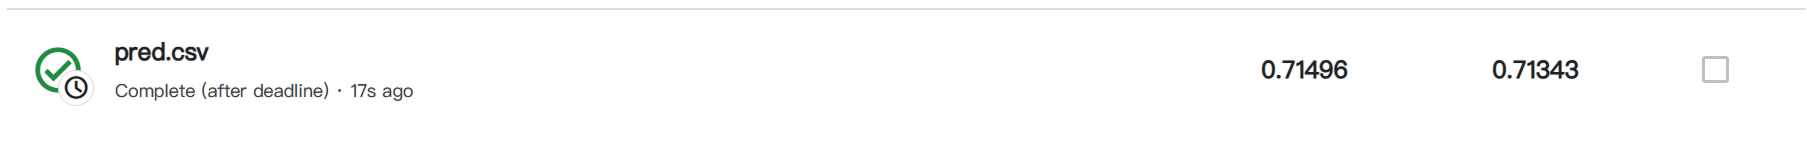